# Import and Data Collection 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import metrics, cv, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("ford.csv")

In [2]:
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0


In [3]:
data.shape

(17966, 9)

In [4]:
data.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17966 entries, 0 to 17965
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17966 non-null  object 
 1   year          17966 non-null  int64  
 2   price         17966 non-null  int64  
 3   transmission  17966 non-null  object 
 4   mileage       17966 non-null  int64  
 5   fuelType      17966 non-null  object 
 6   tax           17966 non-null  int64  
 7   mpg           17966 non-null  float64
 8   engineSize    17966 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 1.2+ MB


In [6]:
data['model'].unique()

array([' Fiesta', ' Focus', ' Puma', ' Kuga', ' EcoSport', ' C-MAX',
       ' Mondeo', ' Ka+', ' Tourneo Custom', ' S-MAX', ' B-MAX', ' Edge',
       ' Tourneo Connect', ' Grand C-MAX', ' KA', ' Galaxy', ' Mustang',
       ' Grand Tourneo Connect', ' Fusion', ' Ranger', ' Streetka',
       ' Escort', ' Transit Tourneo', 'Focus'], dtype=object)

In [7]:
data['model'] = data['model'].str.strip()

# Exploratory Data Analysis (EDA) 

In [8]:
y = data['price']
X = data.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)
df_train = pd.concat([X_train, y_train], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12576 entries, 16464 to 6201
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         12576 non-null  object 
 1   year          12576 non-null  int64  
 2   transmission  12576 non-null  object 
 3   mileage       12576 non-null  int64  
 4   fuelType      12576 non-null  object 
 5   tax           12576 non-null  int64  
 6   mpg           12576 non-null  float64
 7   engineSize    12576 non-null  float64
 8   price         12576 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 982.5+ KB


<Figure size 1000x500 with 0 Axes>

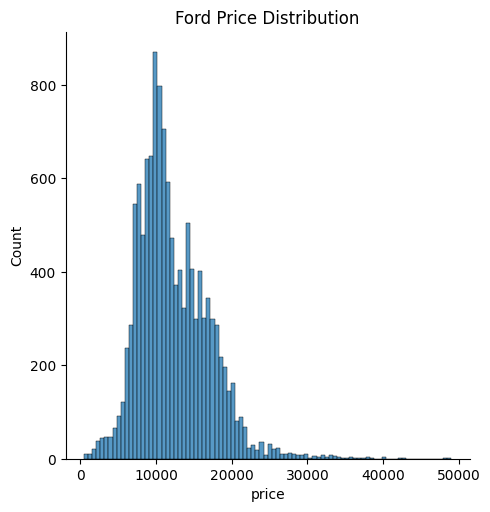

In [9]:
plt.figure(figsize=(10,5))
sns.displot(df_train['price'])
plt.title("Ford Price Distribution")
plt.show()

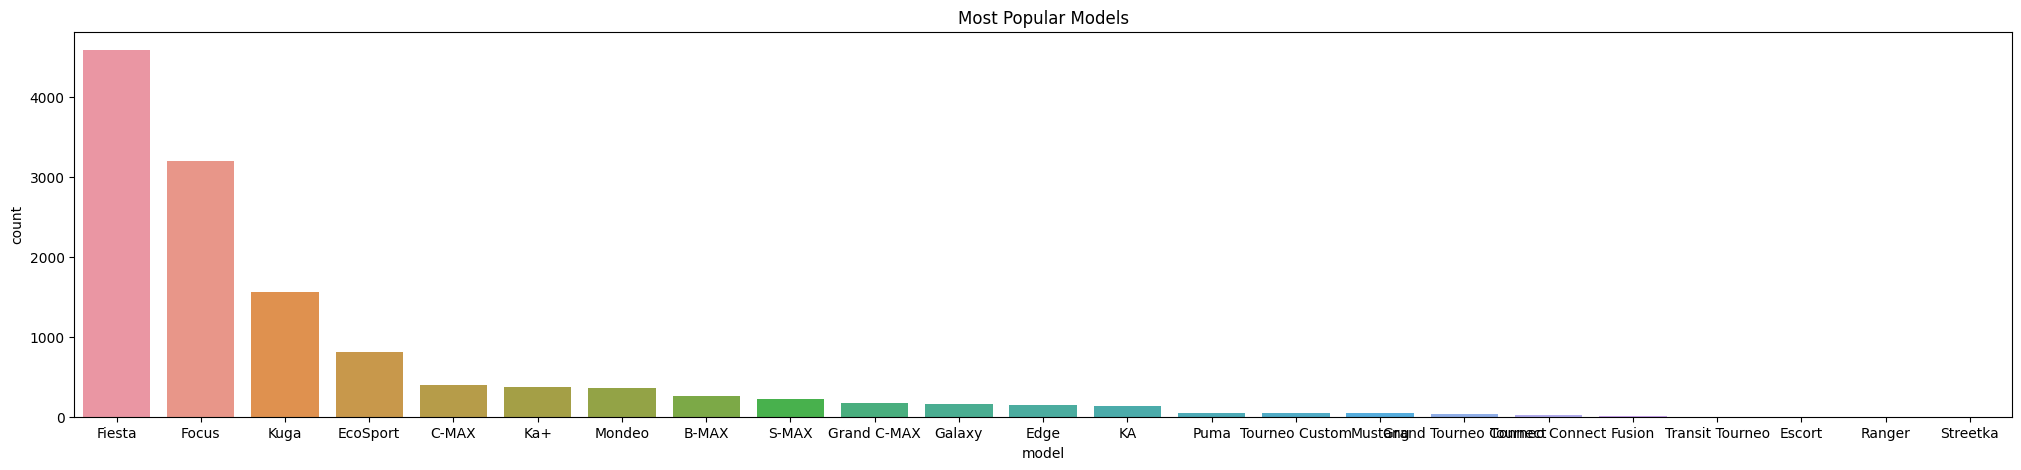

In [10]:
plt.figure(figsize=(25,5))
sns.countplot(x='model', data=df_train, order=df_train['model'].value_counts().index)
plt.title('Most Popular Models')
plt.show()

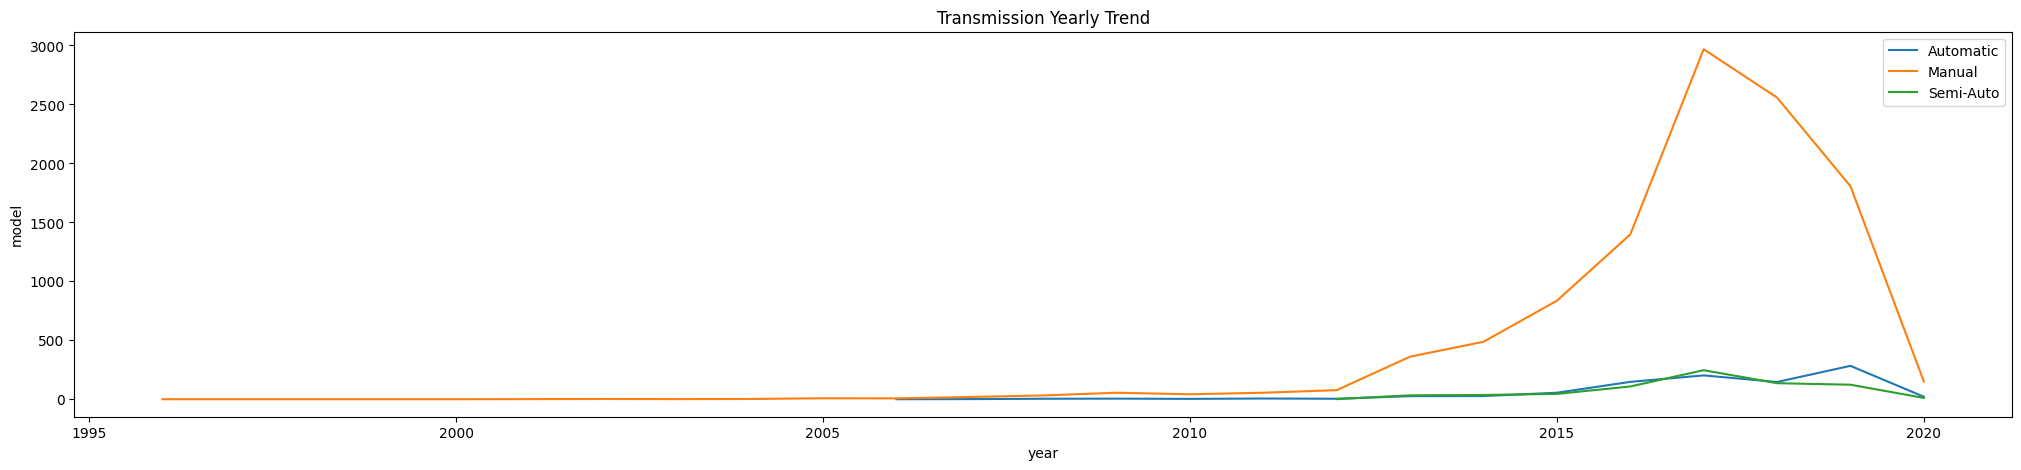

In [11]:
trans_year = df_train.copy().groupby(['transmission','year'],as_index=False).count()
trans_year_auto = trans_year[trans_year['transmission']=='Automatic']
trans_year_man = trans_year[trans_year['transmission']=='Manual']
trans_year_sem = trans_year[trans_year['transmission']=='Semi-Auto']

plt.figure(figsize=(25,5))
sns.lineplot(x='year',y='model',data=trans_year_auto, label='Automatic')
sns.lineplot(x='year',y='model',data=trans_year_man, label='Manual')
sns.lineplot(x='year',y='model',data=trans_year_sem, label='Semi-Auto')
plt.title('Transmission Yearly Trend')
plt.show()


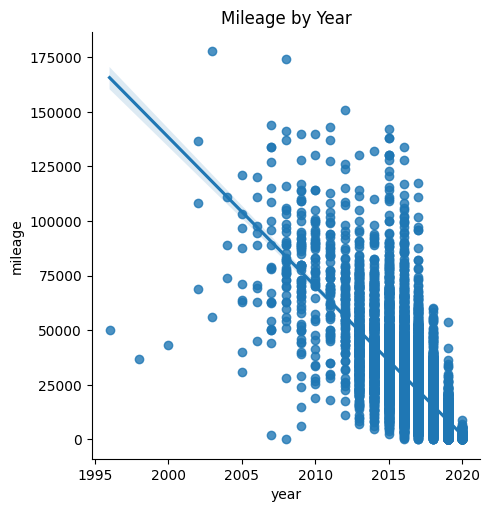

In [12]:
sns.lmplot(x='year',y='mileage',data=df_train)
plt.title('Mileage by Year')
plt.show()

# Data Preprocessing

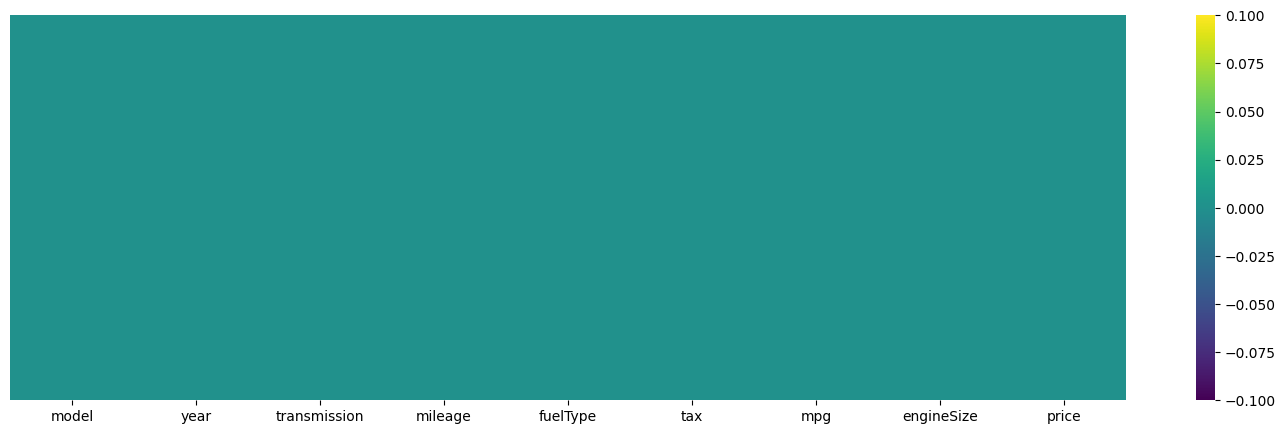

In [13]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df_train.isnull(), yticklabels=False,cmap='viridis')
plt.show()

In [14]:
categorical_cols = ['model', 'transmission', 'fuelType']

X_train_cat = X_train[categorical_cols]
X_train_num = X_train.drop(categorical_cols, axis=1)
X_train_num = X_train_num.reset_index(drop=True)

# One Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat_enc = pd.DataFrame(encoder.fit_transform(X_train_cat))
X_train_cat_enc.columns = encoder.get_feature_names_out(categorical_cols)  # Use get_feature_names_out instead

X_train_mix = pd.concat([X_train_num, X_train_cat_enc], axis=1)

# Scaling
scaler = StandardScaler()
X_train_pre = pd.DataFrame(scaler.fit_transform(X_train_mix))
X_train_pre.columns = X_train_mix.columns


In [15]:
def regression(model):
    reg = model
    reg.fit(X_train_pre, y_train)
    score = cross_val_score(reg, X_train_pre, y_train, cv=5, scoring='r2').mean()
    return reg, score

In [16]:
models = {'LinearRegression':LinearRegression(), 'Ridge':Ridge(),
           'Lasso':Lasso(), 'RandomForestRegressor':RandomForestRegressor(), 
           'CatBoostRegressor':CatBoostRegressor(),
           'DecisionTreeRegressor':DecisionTreeRegressor()}

In [17]:
evaluation_table = pd.DataFrame(columns=['Model', 'R2 Score'])

models = {'LinearRegression':LinearRegression(), 'Ridge':Ridge(),
           'Lasso':Lasso(), 'RandomForestRegressor':RandomForestRegressor(), 
           'CatBoostRegressor':CatBoostRegressor(silent=True),
           'DecisionTreeRegressor':DecisionTreeRegressor()}

for name,model in models.items():
    reg, score = regression(model)
    evaluation_table = evaluation_table.append({'Model': name, 'R2 Score': score},
                                               ignore_index=True)

evaluation_table

,Model,R2 Score
0,LinearRegression,-2.576662e+24
1,Ridge,8.467749e-01
2,Lasso,8.468581e-01
3,RandomForestRegressor,9.278235e-01
4,CatBoostRegressor,9.404453e-01
5,DecisionTreeRegressor,8.886796e-01


In [18]:
cat = CatBoostRegressor(silent=True)
cat.fit(X_train_pre, y_train)

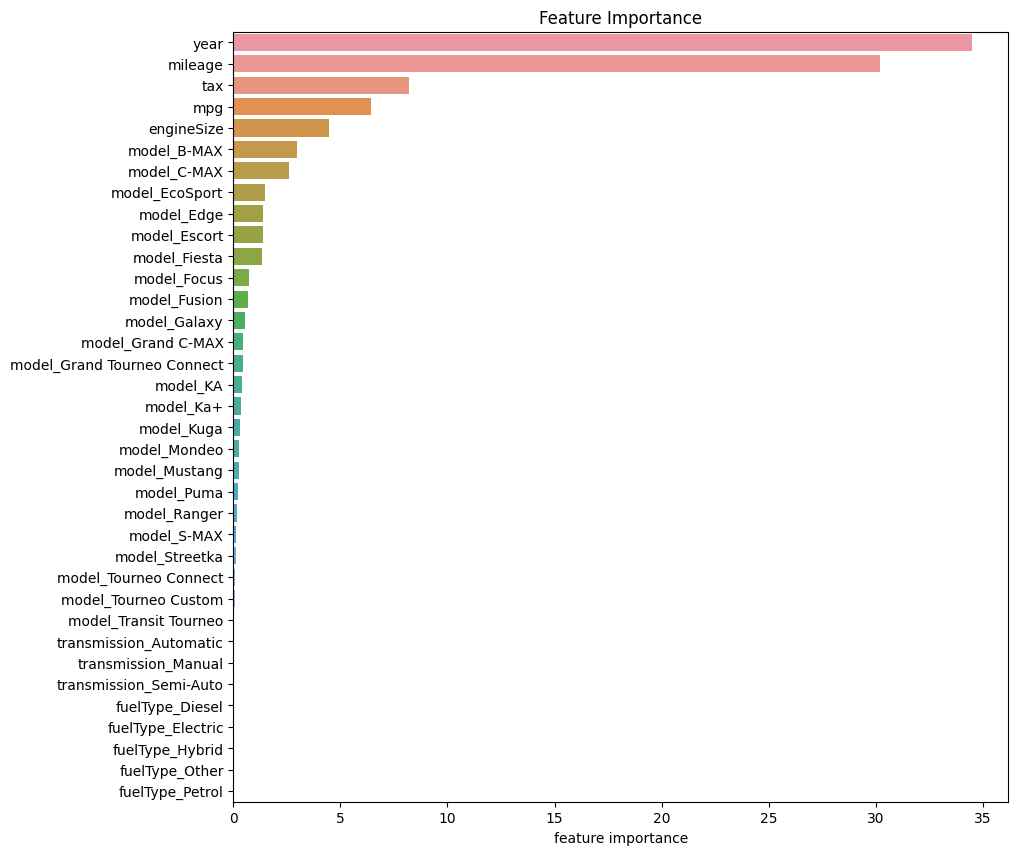

In [19]:
feature_imp = pd.DataFrame(cat.get_feature_importance()).sort_values(by=0,ascending=False)
feature_imp.index = X_train_pre.columns
feature_imp.columns = ['feature importance']

plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp['feature importance'], y=feature_imp.index)
plt.title('Feature Importance')
plt.show()


In [20]:
X_test_cat = X_test[categorical_cols]
X_test_num = X_test.drop(categorical_cols, axis=1)
X_test_num = X_test_num.reset_index(drop=True)
X_test_cat_enc = pd.DataFrame(encoder.transform(X_test_cat))
X_test_cat_enc.columns = encoder.get_feature_names_out(categorical_cols)  # Use get_feature_names_out instead

X_test_mix = pd.concat([X_test_num, X_test_cat_enc], axis=1)

X_test_pre = pd.DataFrame(scaler.transform(X_test_mix))
X_test_pre.columns = X_test_mix.columns


In [21]:
y_pred = cat.predict(X_test_pre)
r2_test = r2_score(y_test, y_pred)
print('Test Score: {:.2%}'.format(r2_test))

Test Score: 94.05%
